In [11]:
import matplotlib.pyplot as plt
import numpy as np
import scipy

%config InlineBackend.figure_format = "retina"

In [12]:
triangle = np.array([[0.0, -2.0], [-2.0, -0], [0.0, 2]])

# Observation coordinates
min_obs_x = -3
max_obs_x = 3
min_obs_y = -3
max_obs_y = 3

n_obs = 20
x_vec = np.linspace(min_obs_x, max_obs_x, n_obs)
y_vec = np.linspace(min_obs_y, max_obs_y, n_obs)
x_grid, y_grid = np.meshgrid(x_vec, y_vec)

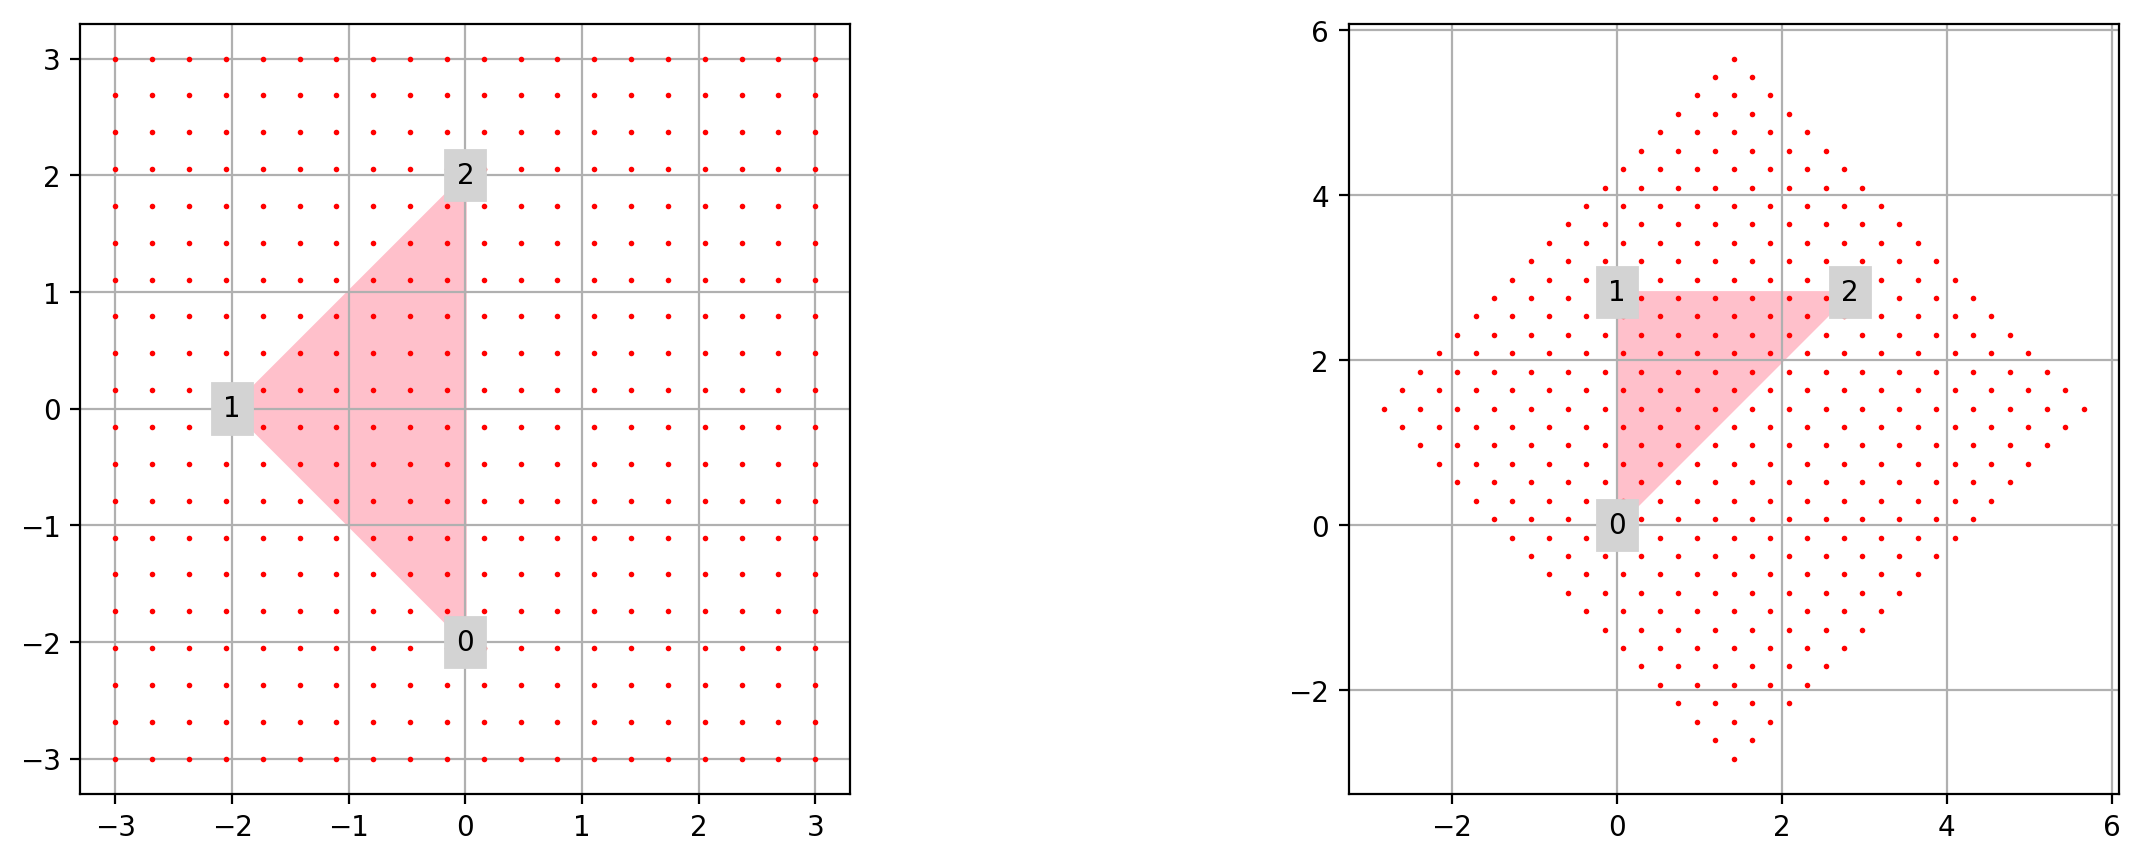

In [13]:
def get_transformed_coordinates(vertices, obs_x, obs_y):
    # Translate the triangle so that the first vertex is at the origin
    translated_vertices = vertices - np.array(vertices[0])
    translated_obs_x = obs_x - vertices[0, 0]
    translated_obs_y = obs_y - vertices[0, 1]

    # Determine the angle to rotate the second vertex to align with the y-axis
    second_vertex = translated_vertices[1]
    angle = np.arctan2(second_vertex[0], second_vertex[1])

    # Rotation matrix to align the second vertex along the positive y-axis
    rotation_matrix = np.array(
        [[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]]
    )
    rotated_vertices = np.dot(translated_vertices, rotation_matrix.T)
    rotated_obs = np.dot(
        np.array([translated_obs_x, translated_obs_y]).T, rotation_matrix.T
    )

    return rotated_vertices, rotated_obs[:, 0], rotated_obs[:, 1]


# Function to plot the triangle
def plot_triangle(vertices):
    plt.fill(vertices[:, 0], vertices[:, 1], color="pink")
    plt.text(
        vertices[0, 0],
        vertices[0, 1],
        "0",
        va="center",
        ha="center",
        backgroundcolor="lightgray",
    )
    plt.text(
        vertices[1, 0],
        vertices[1, 1],
        "1",
        va="center",
        ha="center",
        backgroundcolor="lightgray",
    )
    plt.text(
        vertices[2, 0],
        vertices[2, 1],
        "2",
        va="center",
        ha="center",
        backgroundcolor="lightgray",
    )
    plt.gca().set_aspect("equal", adjustable="box")


# Translate and rotate the triangle
triangle_transformed, obs_x_transformed, obs_y_transformed = (
    get_transformed_coordinates(triangle, x_grid.flatten(), y_grid.flatten())
)

# Plot the original triangle
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plot_triangle(triangle)
plt.plot(x_grid.flatten(), y_grid.flatten(), "r.", markersize=2)
plt.grid()

plt.subplot(1, 2, 2)
plot_triangle(triangle_transformed)
plt.plot(obs_x_transformed, obs_y_transformed, "r.", markersize=2)
plt.grid()
plt.show()

### `scipy.integrate.dblquad` integration
- The triangle $ABC$ is defined in terms of: $A(0,0)$, $B(L_x,dL_y)$, $C(0,L_y)$

In [14]:
LINEWIDTH = 0.5
LEVELS = np.linspace(-0.5, 0.5, 11)


def kelvin_point_source_stress(x, y, xoffset, yoffset, fx, fy, mu, nu):
    x = x - xoffset
    y = y - yoffset
    C = 1 / (4 * np.pi * (1 - nu))
    gx = -C * x / (x**2 + y**2)
    gy = -C * y / (x**2 + y**2)
    gxy = C * 2 * x * y / (x**2 + y**2) ** 2
    gxx = C * (x**2 - y**2) / (x**2 + y**2) ** 2
    gyy = -gxx
    sxx = fx * (2 * (1 - nu) * gx - x * gxx) + fy * (2 * nu * gy - y * gxx)
    syy = fx * (2 * nu * gx - x * gyy) + fy * (2 * (1 - nu) * gy - y * gyy)
    sxy = fx * ((1 - 2 * nu) * gy - x * gxy) + fy * ((1 - 2 * nu) * gx - y * gxy)
    return sxx, syy, sxy


def get_triangle_area(lx, ly, dly):

    # Calculate the lengths of the sides of the triangle
    a = np.sqrt((lx - 0) ** 2 + (dly - 0) ** 2)
    b = np.sqrt((0 - lx) ** 2 + (ly - dly) ** 2)
    c = np.sqrt((0 - 0) ** 2 + (0 - ly) ** 2)

    # Calculate the semi-perimeter of the triangle
    s = (a + b + c) / 2

    # Calculate the area of the triangle using Heron's formula
    triangle_area = np.sqrt(s * (s - a) * (s - b) * (s - c))
    return triangle_area


def plot_stresses(x_grid, y_grid, stresses, triangle, title_string):
    plt.contourf(
        x_grid,
        y_grid,
        stresses,
        cmap="coolwarm",
        levels=LEVELS,
    )
    plt.colorbar(fraction=0.026, pad=0.04, extend="both")
    plt.clim([-0.5, 0.5])
    plt.contour(
        x_grid,
        y_grid,
        stresses,
        colors="gray",
        linestyles="solid",
        linewidths=LINEWIDTH,
        levels=LEVELS,
    )
    plt.fill(triangle[:, 0], triangle[:, 1], facecolor="None", edgecolor="k")
    plt.title(title_string)
    plt.gca().set_aspect("equal")
    plt.xlim([np.min(x_grid), np.max(x_grid)])
    plt.ylim([np.min(y_grid), np.max(y_grid)])


x_offset = 0.0
y_offset = 0.0
fx = 1.0
fy = 0.0
mu = 1.0
nu = 0.25

# Define a triangle region in dblquad style
lx = triangle_transformed[2, 0]
dly = triangle_transformed[2, 1]
ly = triangle_transformed[1, 1]

triangle_area = get_triangle_area(lx, ly, dly)

# Definition of integration limits over a triangle
ymin = lambda x: dly * x / lx
ymax = lambda x: ly - (ly - dly) * x / lx

## Integrate over transformed triangle and observation coordinates

/Users/mallick/miniconda3/envs/bemcs/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


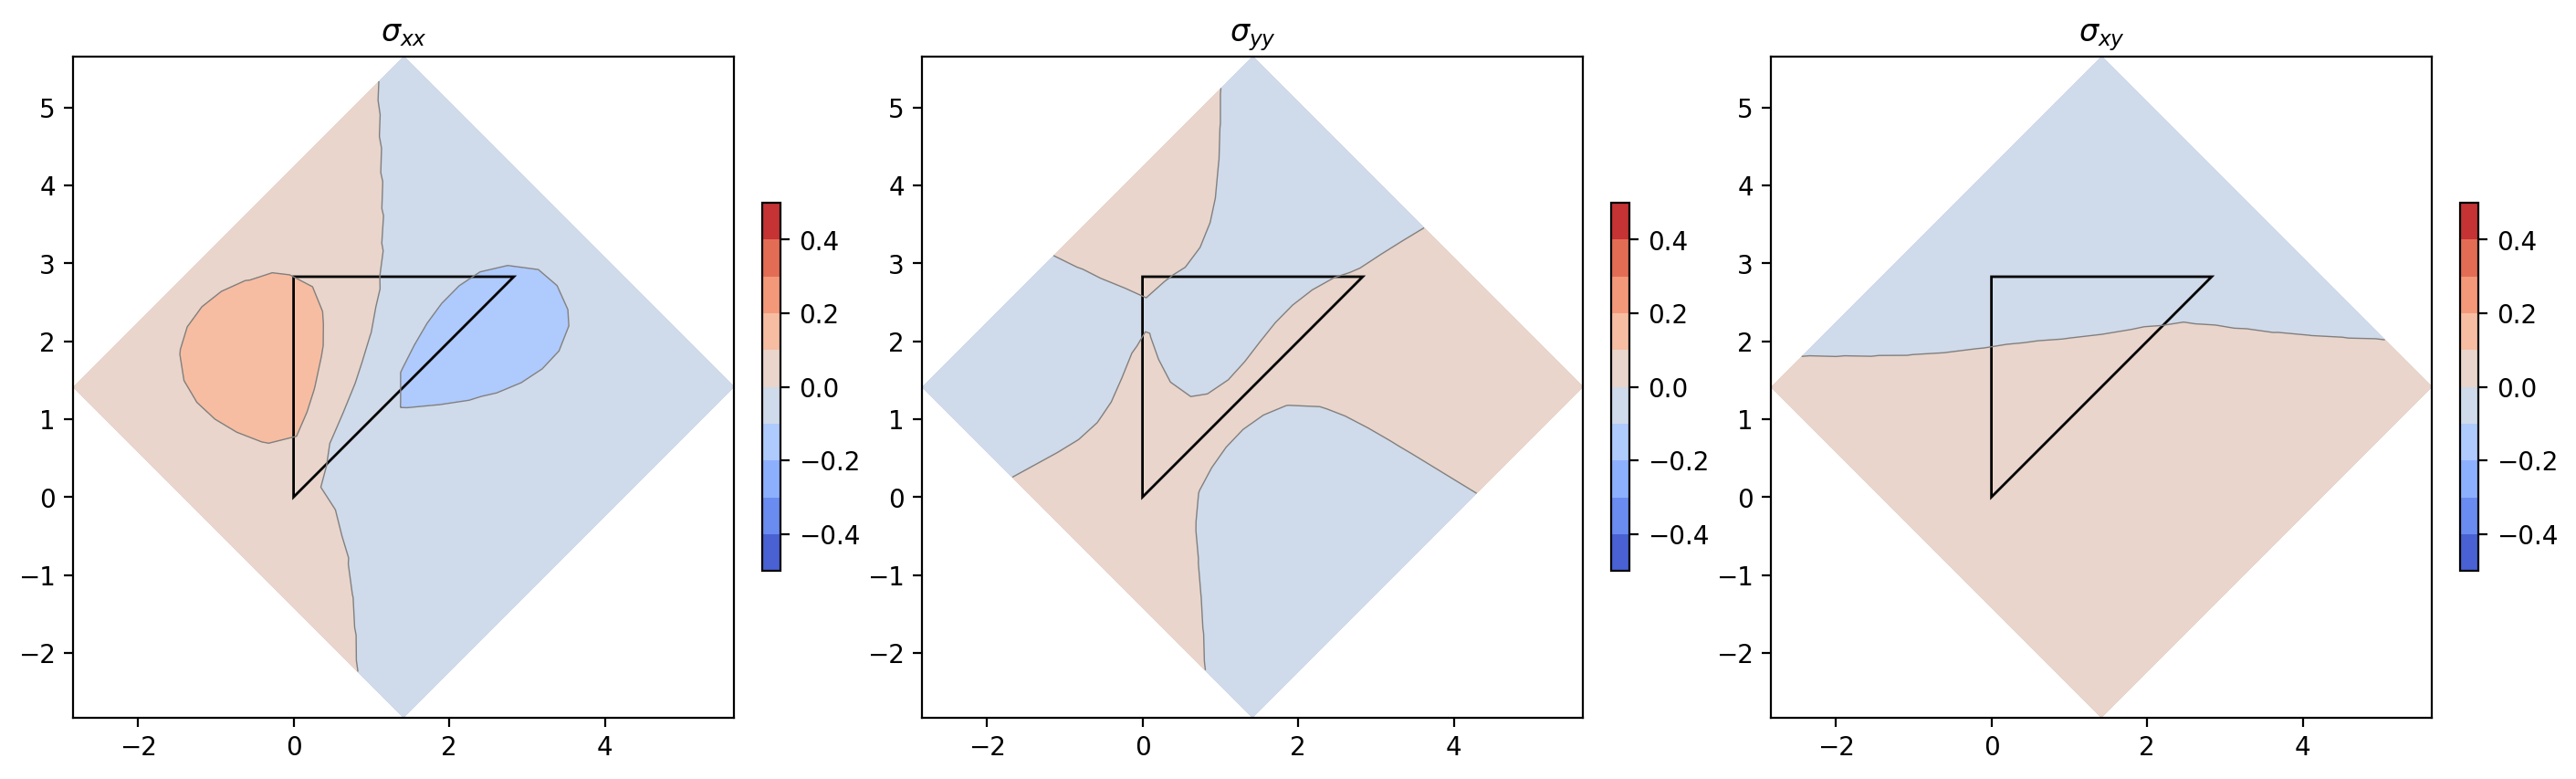

In [15]:
sxx_dblquad = np.zeros_like(obs_x_transformed).flatten()
syy_dblquad = np.zeros_like(obs_x_transformed).flatten()
sxy_dblquad = np.zeros_like(obs_x_transformed).flatten()
for i in range(0, obs_x_transformed.size):
    # xx stress integration
    f = lambda y, x: kelvin_point_source_stress(
        obs_x_transformed.flatten()[i],
        obs_y_transformed.flatten()[i],
        x,
        y,
        fx,
        fy,
        mu,
        nu,
    )[0]
    sol, err = scipy.integrate.dblquad(f, 0, lx, ymin, ymax, epsabs=1e-3)
    sxx_dblquad[i] = sol / triangle_area

    # yy stress integration
    f = lambda y, x: kelvin_point_source_stress(
        obs_x_transformed.flatten()[i],
        obs_y_transformed.flatten()[i],
        x,
        y,
        fx,
        fy,
        mu,
        nu,
    )[1]
    sol, err = scipy.integrate.dblquad(f, 0, lx, ymin, ymax, epsabs=1e-3)
    syy_dblquad[i] = sol / triangle_area

    # xy stress integration
    f = lambda y, x: kelvin_point_source_stress(
        obs_x_transformed.flatten()[i],
        obs_y_transformed.flatten()[i],
        x,
        y,
        fx,
        fy,
        mu,
        nu,
    )[2]
    sol, err = scipy.integrate.dblquad(f, 0, lx, ymin, ymax, epsabs=1e-3)
    sxy_dblquad[i] = sol / triangle_area


x_grid = obs_x_transformed.reshape(n_obs, n_obs)
y_grid = obs_y_transformed.reshape(n_obs, n_obs)
plt.figure(figsize=(17, 6))
plt.subplot(1, 3, 1)
plot_stresses(
    x_grid,
    y_grid,
    np.reshape(sxx_dblquad, (n_obs, n_obs)),
    triangle_transformed,
    "$\sigma_{xx}$",
)

plt.subplot(1, 3, 2)
plot_stresses(
    x_grid,
    y_grid,
    np.reshape(syy_dblquad, (n_obs, n_obs)),
    triangle_transformed,
    "$\sigma_{yy}$",
)

plt.subplot(1, 3, 3)
plot_stresses(
    x_grid,
    y_grid,
    np.reshape(sxy_dblquad, (n_obs, n_obs)),
    triangle_transformed,
    "$\sigma_{xy}$",
)
plt.show()